In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import astropy.table

In [2]:
def gauss(x, A, mu, sigma):
    return abs(A)*np.exp( -(x - mu)**2 / (2 * sigma**2) )

def comet_ingress(x, A, mu, sigma, shape):
    '''exponential comet ingress, `shape` controls curviness'''
    sh = shape/sigma
    norm = 1 - np.exp(-sh*sigma)
    return A/norm*(1 - np.exp(-sh*(x-mu+sigma)))

def comet_curve2(x, A, mu, sigma, tail, shape=3):
    return np.piecewise(x, [x<(mu-sigma), np.logical_and(x>=(mu-sigma), x<mu), x>=mu],
                        [0,
                         lambda t: comet_ingress(t, A, mu, sigma, shape),
                         lambda t: A*np.exp(-abs(t-mu)/tail)])

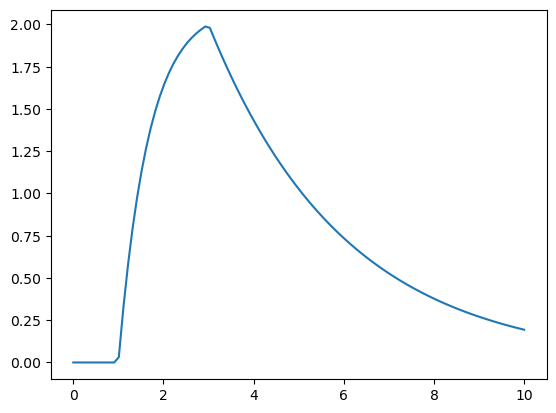

In [3]:
x = np.linspace(0, 10, 100)
A = 2
mu = 3
sigma = 2
shape = 3
norm = 1-np.exp(-sigma)
# plt.plot(x, A/norm*(1-np.exp(-(x-mu+sigma))))
# plt.plot(x, comet_ingress(x, A, mu, sigma))
plt.plot(x, comet_curve2(x, A, mu, sigma, sigma+1, shape=shape))

In [4]:
lc_dir = 'comets10k-nomodel'
out_dir = 'lc_inject'

In [5]:
fs = glob.glob(f'{lc_dir}/*npy')

In [13]:
d = np.load(fs[0])

In [14]:
m = comet_curve2(d[0], 0.5, np.min(d[0])+5, 0.3, 0.3)

(1494.8059364172123, 1498.8059364172123)

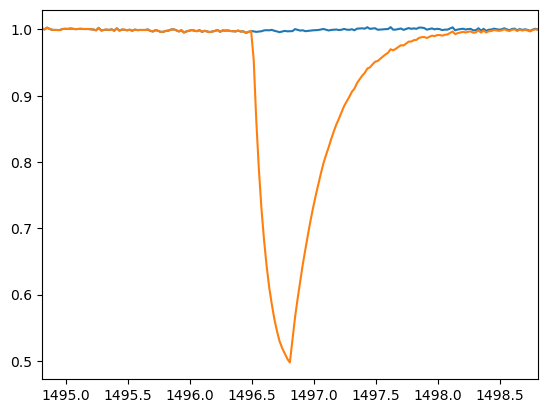

In [15]:
fig, ax = plt.subplots()
ax.plot(d[0], d[1])
ax.plot(d[0], d[1] - m)
ax.set_xlim(np.min(d[0])+5-2, np.min(d[0])+5+2)

In [23]:
tics = []
tpeaks = []
for f in fs:
    d = np.load(f)
    t0 = np.min(d[0])+5
    if np.random.random() > 0.5:
        nc = 50
        rms = d[1] - np.convolve(d[1], np.ones(nc)/nc, mode='same')
        rms = np.nanstd(rms[nc//2:-nc//2])
        dep = np.random.random()*5 + 10
        wid = np.random.random()*0.3 + 0.2
        # wid = 0.3
        m = comet_curve2(d[0], rms*dep, t0, wid, wid)
        d[1] -= m
        tics.append(int(os.path.basename(f).split('_')[0]))
        tpeaks.append(t0+2457000.0)

    # rng = np.nanpercentile(d[1], 99.) - np.nanpercentile(d[1], 0.1)
    # d[1] = ( d[1] - np.nanpercentile(d[1], 0.1) ) / rng
    np.save(f'{out_dir}/{os.path.basename(f)}', d)
    
t = astropy.table.Table({'TIC':tics, 'tpeak':tpeaks})
t.write(f'{out_dir}/inject_catalog.csv', overwrite=True)

In [20]:
print(len(fs), len(t))

1613 795


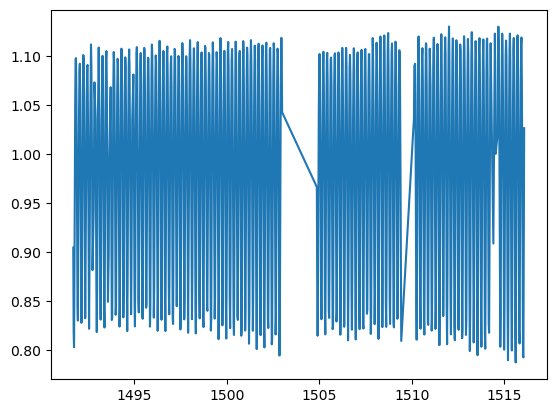

In [22]:
plt.plot(d[0], d[1])